In [2]:
from datetime import datetime
import hdbscan
from pathlib import Path
from typing import Optional
import pandas as pd
from loguru import logger
from sklearn.datasets import make_blobs


In [3]:
import pickle

bbdd="flickr"
dino_model="base"

# Reduction params 
dim_red = "umap"
n_components = 5
min_dist = 0.1
n_neighbors = 5
metric = "euclidean"
norm=True
scaler = "None"


# Load images
path = Path("./data/flickr/flickr_validated_imgs_7000")
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
# Find all image files recursively and filter by extension (lowercase only)
image_paths = [img_path for img_path in path.rglob('*') if img_path.suffix.lower() in image_extensions]
# Convert to lowercase and remove duplicates (especially relevant for Windows)
unique_image_paths = {img_path.resolve().as_posix().lower(): img_path for img_path in image_paths}
images = list(unique_image_paths.values())

# Load cached embeddings already reduced based on params
data = pickle.load(
                open(str(f"cache_embeddings_red/bbdd_{bbdd}_dino_model_{dino_model}--norm_{norm}--scaler_{scaler}--dimred_{dim_red}--reduction_params_metric={metric}_n_components={n_components}_n_neighbors={n_neighbors}_min_dist={min_dist}.pkl"), "rb")
)

print(data)

             0         1         2         3         4
0     2.678764 -0.606406 -0.032275  1.172780  1.257389
1    -1.375359 -1.550557  1.989837 -1.964251 -0.160990
2     1.590983 -0.029678 -0.078153  0.727744 -1.106895
3    -1.348136 -0.000254 -0.272157  1.507219  2.934441
4     1.656070 -2.102522 -0.091459  0.681160 -3.783395
...        ...       ...       ...       ...       ...
7067  2.206087 -1.758617 -0.219990  0.834786 -3.871116
7068 -1.542105 -1.326776  1.557476 -1.618267  0.078575
7069  1.746041  1.510906 -2.133772 -0.924746  4.269979
7070 -1.516019  0.611899  0.199857  0.732062  0.496824
7071 -1.756593 -0.007219  1.514402  0.785210  0.752364

[7072 rows x 5 columns]


In [4]:
# Aplicamos hdbscan

from sklearn.cluster import AgglomerativeClustering

clustering = "hdbscan"
eval_method="silhouette"

if clustering == "hdbscan":

    model = hdbscan.HDBSCAN(
            min_cluster_size=4,
            min_samples=4,
            cluster_selection_epsilon=0.3016430007941225,
            metric='manhattan',
            cluster_selection_method='eom',
            gen_min_span_tree=False,
            prediction_data=True
        )
elif clustering == "agglomerative":
    model =   AgglomerativeClustering(
                n_clusters=300,
                linkage="average",
                metric="euclidean"
            )

labels =model.fit_predict(data)


/home/domin/anaconda3/envs/ces_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/domin/anaconda3/envs/ces_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [5]:
labels

array([ 55, 240, 236, ..., 162,  72, 304])

In [6]:
# Get number of clusters (excluding noise)
from sklearn.metrics import davies_bouldin_score, silhouette_score


n_clusters = len(set(labels)) - (1 if -1 in labels else 0)



score_silhouette = silhouette_score(data[labels != -1], labels[labels != -1])

score_davies = davies_bouldin_score(data[labels != -1], labels[labels != -1])


# Noise points
noise_points = (labels == -1).sum()
# Calcular la proporción de ruido
noise_ratio = noise_points / len(data)


In [7]:
print(score_silhouette)
print(score_davies)
print(noise_points)
print(noise_ratio)

if eval_method == "silhouette":
    score = score_silhouette
else:
    score = score_davies

0.5403887
0.5219882897837993
1458
0.2061651583710407


In [8]:
probs = model.probabilities_
labels = model.labels_
print([x for x in probs])
print(labels)


[1.0, 1.0, 1.0, 0.4977837999817597, 1.0, 1.0, 1.0, 1.0, 0.6439272567556262, 1.0, 1.0, 0.8080902553930078, 0.5033432169759048, 1.0, 0.0, 1.0, 1.0, 1.0, 0.4799196805173192, 1.0, 1.0, 0.9921940433515362, 0.7226628745696588, 1.0, 0.4176183563895836, 0.8617882829863961, 1.0, 0.4885346037423658, 0.26122487212988726, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.5200892511432592, 1.0, 1.0, 0.3400377340541912, 0.9344928196451039, 0.4734413948525408, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.9503108426422348, 1.0, 1.0, 1.0, 1.0, 0.6411631127675607, 0.1913018251320426, 1.0, 0.0, 1.0, 1.0, 0.9165305911765631, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.9787293644275519, 1.0, 1.0, 1.0, 0.19023161450798323, 0.0, 0.0, 0.0, 0.4422611239593375, 1.0, 0.0, 0.6387641353650036, 0.5279015612266693, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.247453849911632, 0.9838447251004722, 0.0, 1.0, 0.0, 0.7850129288418469, 0.933955793479852, 0.0, 1.0, 0.0, 0.5461734926764851, 0.0, 0.6603817850291327, 1.0, 1.0, 1.0, 1.0, 1.0, 0.733927754104

In [9]:
probs = hdbscan.all_points_membership_vectors(model)

In [10]:
print(probs)

[[5.34269500e-308 5.80704062e-308 7.77637777e-308 ... 2.47483404e-307
  2.60362777e-307 2.51540649e-307]
 [5.68392696e-308 8.19263419e-308 5.63890711e-308 ... 1.45055903e-307
  1.33397526e-307 1.38265944e-307]
 [5.84299430e-308 6.71565176e-308 7.42546020e-308 ... 5.98062626e-307
  5.47441873e-307 6.27190989e-307]
 ...
 [4.57555028e-308 4.94811828e-308 5.82399431e-308 ... 1.28058010e-307
  1.28734162e-307 1.33287569e-307]
 [4.90908493e-308 6.96141066e-308 6.00652034e-308 ... 2.31465161e-307
  2.24226819e-307 2.35279875e-307]
 [5.07329010e-308 6.70771594e-308 5.72783778e-308 ... 1.67415784e-307
  1.62820447e-307 1.69823088e-307]]


In [11]:
import numpy as np

noise_indices = np.where(labels == -1)[0]

In [12]:
# Ejemplo: recopilamos el clúster con mayor probabilidad para cada punto ruido
# y guardamos la información en una lista de dicts.
records = []
for idx in noise_indices:
    # Vector de probabilidades del punto 'idx'
    prob_vector = probs[idx]

    # Ordenamos las probabilidades de mayor a menor
    sorted_cluster_indices = np.argsort(prob_vector)[::-1]
    
    # Tomamos los índices de los 2 clusters más probables
    top_clusters = sorted_cluster_indices[:1]
    top_probs = prob_vector[top_clusters]

    records.append({
        'point_index': idx,
        'cluster_1': top_clusters[0],
        'prob_1': top_probs[0]
    })

In [13]:
import pandas as pd

df_noise_probs = pd.DataFrame(records)
df_noise_probs.where(df_noise_probs["prob_1"] > 0.05).sort_values(by="prob_1", ascending=False).head(20)  

,point_index,cluster_1,prob_1
374,1762.0,46.0,0.304379
1018,4932.0,128.0,0.204867
110,530.0,172.0,0.161085
1284,6288.0,164.0,0.159708
421,2012.0,46.0,0.140452
309,1491.0,248.0,0.133292
1325,6428.0,164.0,0.127118
898,4351.0,164.0,0.119489
499,2420.0,46.0,0.115044
112,536.0,166.0,0.113146


In [14]:
# #Asignar al clúster con mayor probabilidad (ha de ser superior al 10%)

# import numpy as np

# # Supongamos que ya tienes:
# # 1. labels: las etiquetas "duras" de HDBSCAN (model.labels_)
# # 2. probs: la matriz de pertenencias blandas => all_points_membership_vectors(model)
# #    donde probs.shape = (n_samples, n_clusters_sin_incluir_ruido)

# # Indices de los puntos ruido
# noise_indices = np.where(labels == -1)[0]

# # Reasignamos cada punto ruido
# for idx in noise_indices:
#     prob_vector = probs[idx]          # Vector de pertenencia al resto de clusters
#     best_cluster = np.argmax(prob_vector)    # Índice del clúster con mayor probabilidad
#     best_prob = prob_vector[best_cluster]    # Probabilidad más alta

#     # Si esa probabilidad supera el 10% (0.1), reasignamos la etiqueta
#     if best_prob >= 0.01:
#         labels[idx] = best_cluster
#     # Si no, se mantiene en -1 (ruido)


In [15]:
from collections import Counter


cluster_images_dict = {}
for i, label in enumerate(labels):
            if label not in cluster_images_dict:
                cluster_images_dict[label] = []
            cluster_images_dict[label].append(images[i])
    
cluster_images_dict = dict(sorted(cluster_images_dict.items()))

print(cluster_images_dict)
label_counter = Counter(labels)
print(len(label_counter.keys()))
print(label_counter)

{-1: [PosixPath('data/flickr/flickr_validated_imgs_7000/guadarrama_NA_4269_50814262142__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/snev_NA_2110_41642742851__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/picos_NA_3258_50365711787__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/picos_NA_5943_33757987434__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/aiguestortes_NA_4792_16179367894__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/teide_NA_861_52557364868__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/snev_NA_2893_16914940602__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/aiguestortes_NA_4458_50036516237__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/guadarrama_NA_3864_22444368764__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/sierra_nieves_NA_3376_30281427754__b.jpg'), PosixPath('data/flickr/flickr_validated_imgs_7000/guadarrama_NA_3618_52733074327__b.jpg'), PosixPath('dat

In [16]:

import os
import shutil

from pathlib import Path


def create_cluster_dirs(images_dict, copy_images=True):
    """
    Create a dir for every cluster given in dictionary of images. 
    Move images to those clusters dirs
    Create csv with images asigned to each cluster
    Create pdf with knn(30) closest images to centroid asigned to each cluster
    """
    # logger.info("Copying images from Data path to cluster dirs")
    # For every key (cluster index)
    
    # Get all images in dict format asigned to cluster
    images_dict_format = images_dict
    path_cluster = Path.cwd() / "clusters" / "imgs"
    if os.path.exists(path_cluster):
        shutil.rmtree(path_cluster)
    cluster_data = []
    try:
        for cluster_id, image_paths in images_dict_format.items():
            # Create folder if it doesnt exists
            cluster_dir = os.path.join(path_cluster, str(cluster_id)) 
            os.makedirs(cluster_dir, exist_ok=True)
            # For every path image, copy that image from its path to cluster folder
            for image_path in image_paths:
                cluster_data.append([cluster_id, image_path])
                if copy_images:
                    shutil.copy(image_path, cluster_dir)
        #Guardar el CSV con la información de imágenes y sus clusters
        csv_path = Path.cwd() / "clusters" / "cluster_images.csv"
        df = pd.DataFrame(cluster_data, columns=["cluster", "img"])
        df.sort_values(by="cluster").to_csv(csv_path, index=False)
    except (os.error) as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message)

create_cluster_dirs(cluster_images_dict)

In [17]:
# Create metrics
from multimodal_clustering_metric import MultiModalClusteringMetric

cluster_images = cluster_images_dict

categories_df = pd.read_csv("data/classification_lvls/classification_level_3.csv", sep=";", header=0).iloc[:, 0].tolist()
categories = [cat.upper() for cat in categories_df]

llava_results_df = pd.read_csv("data/results_llava/flickr/classification_lvl_3/llava1-6_7b/prompt_4/inference_results.csv", sep=";", header=0)
llava_results_df['category_llava'] = llava_results_df['category_llava'].apply(lambda x: x.upper())

lvm_lvlm_metric = MultiModalClusteringMetric("experiment_actual",
                                            10,
                                            categories,
                                            clustering,
                                            eval_method,
                                            score,
                                            model, 
                                            10, 
                                            cluster_images_dict, 
                                            llava_results_df)
lvm_lvlm_metric.eval_method = eval_method
lvm_lvlm_metric.clustering = clustering
lvm_lvlm_metric.score = score

lvm_lvlm_metric.generate_stats()


quality_results = pd.DataFrame()
for i in (True, False):
    # Calculate metrics
    results = lvm_lvlm_metric.calculate_clustering_quality(use_noise=i)
    # Join results (in columns)
    quality_results = pd.concat([quality_results, pd.DataFrame([results])], axis=1)

print(f"homogeneity_global: {quality_results['homogeneity_global'].iloc[0]}")
print(f"entropy_global: {quality_results['entropy_global'].iloc[0]}")
print(f"quality_metric: {quality_results['quality_metric'].iloc[0]}")

lvm_lvlm_metric.plot_cluster_categories_3()

homogeneity_global: 0.6793729960812255
entropy_global: 1.2860026543150274
quality_metric: 0.5282823215950225


In [18]:
# Añado clúster a la inferencia de Llava
inference_with_cluster = lvm_lvlm_metric.add_cluster_to_llava_inference().sort_values(by="cluster")
# Me quedo con la categoría mayoritaria para dicho clúster con cierto nivel de homogeneidad (primero con todo luego filtro)
stats_unique = lvm_lvlm_metric.result_stats_df[["cluster","predominant_category","homogeneity_k"]].drop_duplicates()
# Uno la inferencia del clúster con este resultado, y añado la columna de predominant_category y homoegeneity_k
stats_unique.rename(columns={"predominant_category":"predominant_category_llava"}, inplace=True)
imgs_with_predominant_category = inference_with_cluster.merge(stats_unique[["cluster","predominant_category_llava","homogeneity_k"]], on="cluster", how="left")
llava_classification = imgs_with_predominant_category[["cluster","img","predominant_category_llava","homogeneity_k"]]
# Mergeamos con el resultado de etiquetado manual
manual_classification = pd.read_csv("data/results_manual_annotation/inference_results.csv", sep=";", header=0)
manual_classification['manual_category'] = manual_classification['manual_category'].apply(lambda x: x.upper())
# Unimos ambos por imagen
result = llava_classification.merge(manual_classification[["img","manual_category"]],on="img",how="left")

# Hay una que se queda NA, creo que es por algo del formato:
# Rellenamos con roads que es lo que Carlos ha puesto, pero no lo coge
result['manual_category'] = result['manual_category'].astype(str).fillna("ROADS")

print(result.head(10).to_string())

result.to_csv("df_final.csv",sep=";")


   cluster                                    img predominant_category_llava  homogeneity_k          manual_category
0       -1      ordesa_NA_2156_44667090414__b.jpg       HERITAGE AND CULTURE       0.355281   OTHER ABIOTIC FEATURES
1       -1       picos_NA_2763_51630067496__b.jpg       HERITAGE AND CULTURE       0.355281  VEGETATION AND HABITATS
2       -1       teide_NA_2284_38597877646__b.jpg       HERITAGE AND CULTURE       0.355281                    ROADS
3       -1       teide_NA_2027_52589661987__b.jpg       HERITAGE AND CULTURE       0.355281  VEGETATION AND HABITATS
4       -1  guadarrama_NA_4578_20046753556__b.jpg       HERITAGE AND CULTURE       0.355281                  ANIMALS
5       -1        snev_NA_1707_49999226246__b.jpg       HERITAGE AND CULTURE       0.355281       TOWNS AND VILLAGES
6       -1        snev_NA_6383_23163161182__b.jpg       HERITAGE AND CULTURE       0.355281       TOWNS AND VILLAGES
7       -1       teide_NA_1926_33737586483__b.jpg       HERITAGE

In [19]:
nan_rows = result[result.isna().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [cluster, img, predominant_category_llava, homogeneity_k, manual_category]
Index: []


In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para filtrar y graficar
def plot_line_chart(df, metric_name):
    df = df.fillna(0)  # Reemplaza NaN con 0
    df = df.loc[(df != 0).any(axis=1)]  # Filtrar filas donde al menos un valor es distinto de 0

    if df.empty:
        print("No hay datos para graficar después del filtrado.")
        return

    # Transponer el DataFrame para que los umbrales estén en el eje X
    df_t = df.T

    # Crear la figura
    plt.figure(figsize=(12, 6))

    # Graficar cada categoría con líneas
    for category in df_t.columns:
        plt.plot(df_t.index, df_t[category], marker='o', linestyle='-', label=category, alpha=0.7)

    # Configurar etiquetas y título
    plt.xlabel('Umbral de la métrica')
    plt.ylabel(metric_name)
    plt.title(f'Evolución de {metric_name} por Categoría')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Leyenda fuera de la gráfica
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()





PRECISION
                                              0.9 : 5944  0.8 : 4865  0.7 : 4285  0.6 : 3428  0.5 : 2717
AIR ACTIVITIES                                  0.000000    0.000000    0.000000    0.653846    0.653846
ANIMALS                                         0.957746    0.951807    0.915033    0.903485    0.906329
BAD_INFERENCE                                   0.000000    0.000000    0.000000    0.000000    0.000000
BRIDGE                                          0.666667    0.745192    0.718615    0.720339    0.720339
CITIES                                          0.000000    0.000000    0.000000    0.000000    0.000000
COMMERCE FACILITIES                             0.000000    0.000000    0.000000    0.000000    0.500000
FUNGUS                                          0.000000    0.000000    0.960000    0.960000    0.960000
HERITAGE AND CULTURE                            0.294915    0.151439    0.149479    0.154412    0.145280
KNOWLEDGE                                 

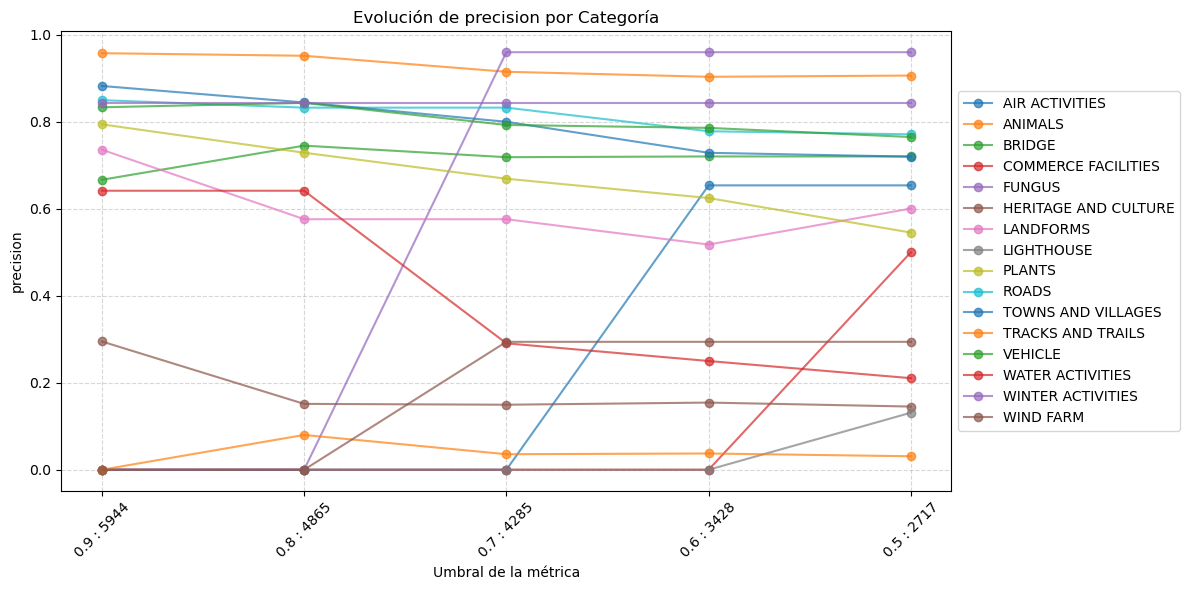




RECALL
                                              0.9 : 5944  0.8 : 4865  0.7 : 4285  0.6 : 3428  0.5 : 2717
AIR ACTIVITIES                                  0.000000    0.000000    0.000000    0.894737    0.850000
ANIMALS                                         0.641509    0.759615    0.828402    0.846734    0.826790
BAD_INFERENCE                                   0.000000    0.000000    0.000000    0.000000    0.000000
BRIDGE                                          0.916667    0.987261    0.988095    0.977011    0.965909
CITIES                                          0.000000    0.000000    0.000000    0.000000    0.000000
COMMERCE FACILITIES                             0.000000    0.000000    0.000000    0.000000    0.224806
FUNGUS                                          0.000000    0.000000    0.960000    0.960000    0.960000
HERITAGE AND CULTURE                            0.977528    0.909774    0.843137    0.831683    0.820833
KNOWLEDGE                                    

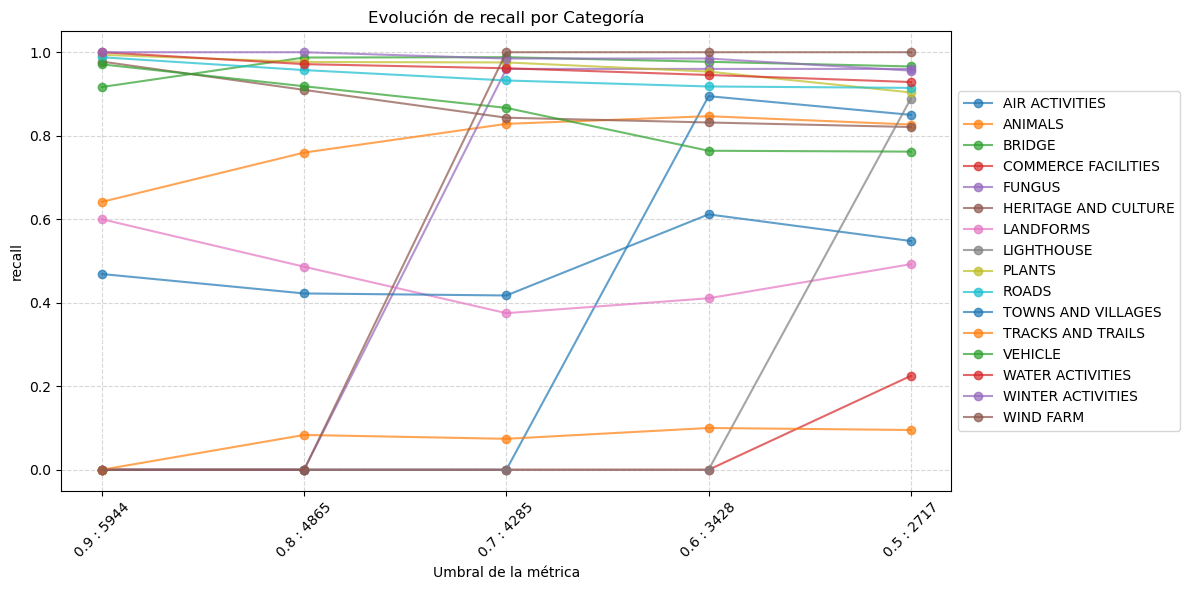




F1-SCORE
                                              0.9 : 5944  0.8 : 4865  0.7 : 4285  0.6 : 3428  0.5 : 2717
AIR ACTIVITIES                                  0.000000    0.000000    0.000000    0.755556    0.739130
ANIMALS                                         0.768362    0.844920    0.869565    0.874189    0.864734
BAD_INFERENCE                                   0.000000    0.000000    0.000000    0.000000    0.000000
BRIDGE                                          0.771930    0.849315    0.832080    0.829268    0.825243
CITIES                                          0.000000    0.000000    0.000000    0.000000    0.000000
COMMERCE FACILITIES                             0.000000    0.000000    0.000000    0.000000    0.310160
FUNGUS                                          0.000000    0.000000    0.960000    0.960000    0.960000
HERITAGE AND CULTURE                            0.453125    0.259657    0.253937    0.260465    0.246867
KNOWLEDGE                                  

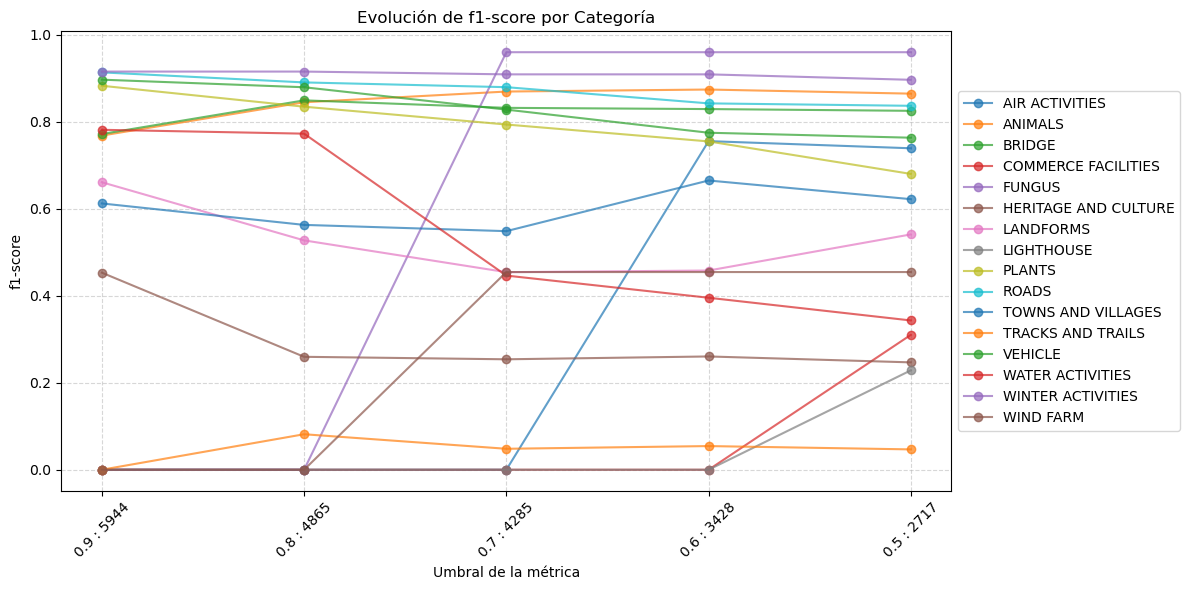

In [43]:
# Calculamos métrica por categoría
from sklearn.metrics import classification_report, accuracy_score


homogeneity_thresholds = [0.9, 0.8, 0.7, 0.6, 0.5]
metrics_to_analyze = ["precision","recall","f1-score"]

# Diccionario para almacenar los resultados
resultados = {}

for j in metrics_to_analyze:
    for i in homogeneity_thresholds:
        df_filtrado = result[result["homogeneity_k"] >= i]
        df_eliminado = result[result["homogeneity_k"] < i]
        n_imagenes_eliminadas = df_eliminado.shape[0]

        report = classification_report(
            df_filtrado['manual_category'], 
            df_filtrado['predominant_category_llava'], 
            output_dict=True, 
            zero_division=0)
        
        # Extraemos la precisión por categoría
        precision_por_categoria = {cat: valores[j] for cat, valores in report.items() if cat not in ["nan","accuracy", "macro avg", "weighted avg"]}

        # Guardamos los resultados en un diccionario donde cada clave es una categoría
        for categoria, precision in precision_por_categoria.items():
            if categoria not in resultados:
                resultados[categoria] = {}  # Inicializamos si no existe
            resultados[categoria][f"{i} : {n_imagenes_eliminadas}"] = precision  # Guardamos el valor con threshold como clave

    # Convertimos a DataFrame
    df_resultados = pd.DataFrame(resultados)

    # Transponemos para que las categorías sean el índice y los thresholds las columnas
    df_resultados = df_resultados.T

    # Mostramos el DataFrame resultante
    print("\n\n\n"+j.upper())
    print(df_resultados.to_string())
    # Llamar a la función con tu DataFrame
    plot_line_chart(df_resultados, j)  # Puedes cambiar 'Precisión' por 'Recall' o 'F1-Score'
